<a href="https://colab.research.google.com/github/tocom242242/notebooks/blob/master/pytorch/vit_feature_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import timm
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
model = timm.create_model('vit_base_patch16_224', pretrained=True,num_classes=0)
model.eval()
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

In [3]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

n_samples = len(testset)
train_size = int(len(testset) * 0.7)
val_size = n_samples - train_size
kwargs = {'num_workers': 2, 'pin_memory': False}
train_dataset, trainset = torch.utils.data.random_split(testset, [train_size, val_size])
test_loader = DataLoader(
    trainset, batch_size=64, shuffle=False, **kwargs)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
import matplotlib.pyplot  as plt
import numpy as np
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


def plot_scatter(x_test,y_test):
    scatter_x = x_test[:, 0]
    scatter_y = x_test[:, 1]
    

    fig, ax = plt.subplots()
    for g in np.unique(y_test):
        ix = np.where(y_test == g)
        ax.scatter(scatter_x[ix], scatter_y[ix],  label = g, s = 10)
    plt.legend()


def plot_features(model, device, data_loader):
    model.to(device)
    feature_space = []
    labels = []
    with torch.no_grad():
        for (imgs, label) in tqdm(data_loader, desc='feature extracting'):
            imgs = imgs.to(device)
            features = model(imgs)
            feature_space.append(features)
            labels.append(label)
        feature_space = torch.cat(feature_space, dim=0).contiguous().cpu().numpy()
        labels = torch.cat(labels, dim=0).cpu().numpy()
    X_reduced_test = TSNE(n_components=2, random_state=0).fit_transform(feature_space)
    plot_scatter(X_reduced_test,labels)

feature extracting: 100%|██████████| 47/47 [00:39<00:00,  1.20it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


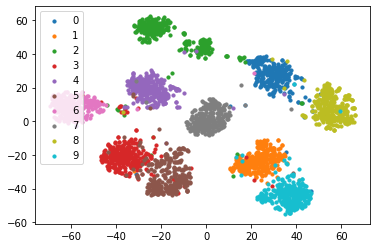

In [7]:
plot_features(model, device, test_loader)